Из банка стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. В датасете представлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Необходимо построить модель с предельно большим значением *F1*-меры. 

Дополнительно необходимо измерить *AUC-ROC* и сравнить её значение с *F1*-мерой.

## Подготовка данных

Импортируем библиотеки

In [34]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from catboost import CatBoost, CatBoostClassifier
from catboost import Pool

from sklearn.dummy           import DummyClassifier
from sklearn.ensemble        import RandomForestClassifier
from sklearn.linear_model    import LogisticRegression
from sklearn.metrics         import f1_score, plot_roc_curve
from sklearn.metrics         import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing   import StandardScaler
from sklearn.tree            import DecisionTreeClassifier
from sklearn.utils           import shuffle

Сохраним датафрейм в переменую

In [8]:
df = pd.read_csv('')

Создадим и применим функцию для описания данных в датафрейме

In [9]:
def exploring(df):
    print('----------- Описание данных -----------')
    display(df.head(10))
    print('---------------------------------------')
    display(df.info())
    print('---------------------------------------')
    display(df.describe().T)
    print('---------------------------------------')
    display(df.describe(include=[object]).T)
    print('---------------------------------------')
    for column in df.columns:
        print('-------------------------')
        print(column,' : кол-во 0:', df[df[column] == 0][column].count(),
        ', процент 0:', round(df[df[column] == 0][column].count()/len(df)*100, 2),'%', 
        ', кол-во NaN:', df[column].isna().sum(), 
        ', процент NaN:', round(df[column].isna().sum()/len(df)*100, 2),'%')
    print('---------------------------------------')
    print('Количество строк-дубликатов:', df.duplicated().sum())

Итак, мы имеем 9% пропусков в столбце `Tenure`. Заменим эти пропуски медианой. В принципе, среднее почти равно медиане, тут не особо важно что из этого мы выберем.

In [10]:
df = df.fillna(df['Tenure'].median())
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Кроме пропусков, у нас тут есть категориальные признаки. Это `Surname`, `Geography` и `Gender`. Последние два преобразуем в дамми-признаки при помощи прямого кодирования, а вот `Surname` нам не должен пригодиться вообще. 

Начнем с того, что избавимся от этого столбца, чтобы не наплодить 10000 дамми-признаков. Заодно удалим `RowNumber` и `CustomerId`. Ни один из этих признаков не будет полезен для наших моделей.

In [11]:
#удаляем бесполезное
df = df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

In [13]:
#плодим дамми-признаки
df = pd.get_dummies(df, drop_first=True)
df.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0


Три страны и два пола. Не все из них попали в таблицу, но этого мы и хотели.

С таком датафреймом можно дальше работать. Но сперва, проведем заключительную проверку. Исследуем на мультиколлениарность. Вдруг получится что-нибудь еще удалить.

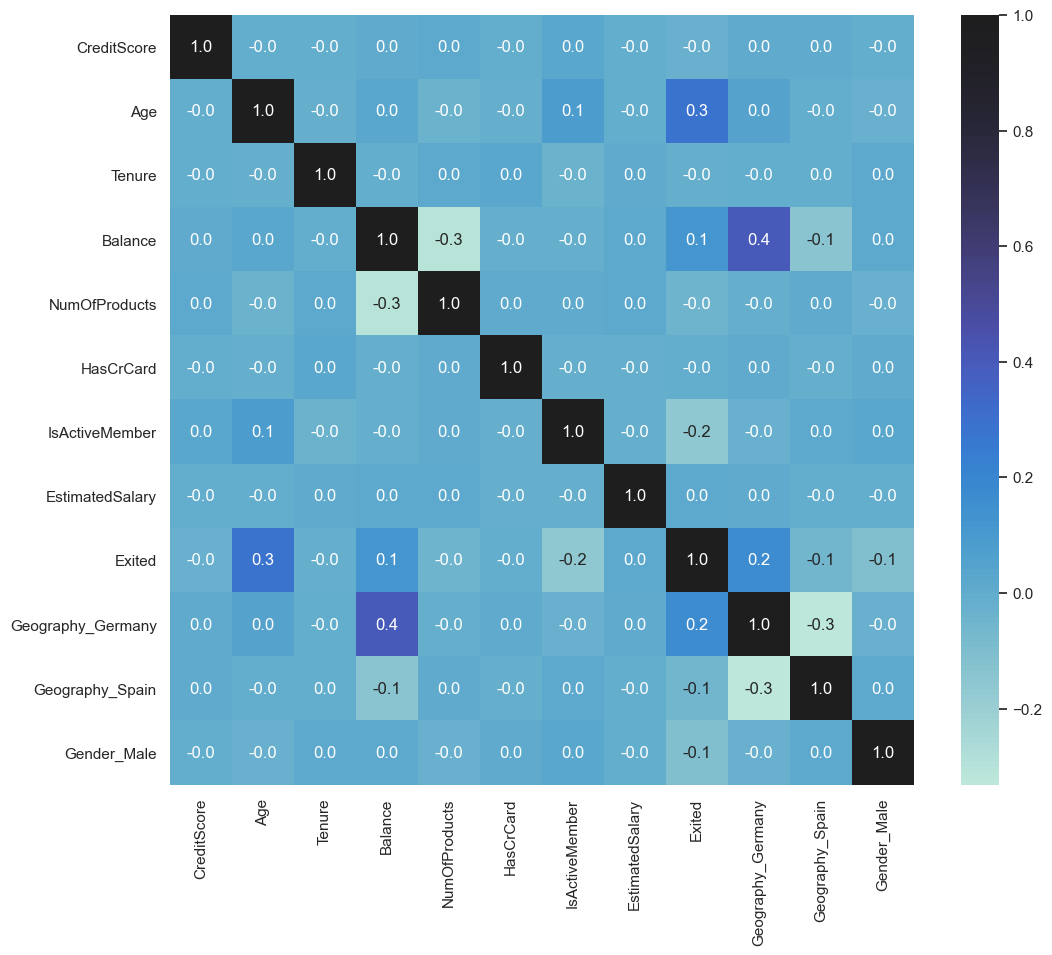

In [14]:
corr = df.corr()
sns.set(rc = {'figure.figsize':(12,10)})
sns.heatmap(corr, 
            xticklabels=corr.columns, 
            yticklabels=corr.columns, 
            annot=True, 
            fmt=".1f", 
            center = True);

Сильные взаимосвязи отсутствуют, поэтому приступим к исследованию.

## Моделирование

### Исследуем баланс классов
Начнем с исследования баланса классов.

In [15]:
df.Exited.value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

4 к 1 - неслабый дисбаланс. Во всех рассматриваемых нами моделях предусмотрен баланс весов категорий. Он то нам и поможет

### Моделирование
Определимся с фичами и таргетами.

In [16]:
features = df.drop('Exited', axis=1)
target = df['Exited']
display(features.shape, target.shape)

(10000, 11)

(10000,)

При разбиении воспользуемся формулой 3:1 (train:test).

Начнем с разделения на тренировочную и тестовую выборки.

In [21]:
X_train, X_test, y_train, y_test = train_test_split(features, 
                                                    target, 
                                                    test_size=0.2, 
                                                    random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8000, 11), (2000, 11), (8000,), (2000,))

Роскошно! Займемся масштабированием признаков!

In [22]:
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']

scaler = StandardScaler()

features_train[numeric] = scaler.fit_transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric]) 

C:\Users\luche\AppData\Local\Temp\ipykernel_16424\3533769557.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_train[numeric] = scaler.fit_transform(features_train[numeric])
c:\Users\luche\anaconda3\envs\practicum\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
C:\Users\luche\AppData\Local\Temp\ipykernel_16424\3533769557.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

### Логистическая регрессия
Начнем с простого и быстрого

In [23]:
# выделим параметры для перебора
lr_param_grid = {'C': [0.01, 0.1, 1.0, 10, 100],
             'tol': [0.0001, 0.001, 0.01, 0.1, 1]}

# объявим модель
lr = LogisticRegression(class_weight='balanced', 
                        max_iter=1000, 
                        random_state = 42)

# займемся перебором
lr_grid = GridSearchCV(lr, lr_param_grid, scoring='f1')
lr_grid.fit(X_train, y_train)
lr_grid.best_estimator_

LogisticRegression(C=0.01, class_weight='balanced', max_iter=1000,
                   random_state=42)

Найдем F1, построим ROC-график, чтобы увидеть насколько модель лучше, чем простой рандом. Заодно посмотрим на матрицу ошибок. 

In [24]:
def scoring(model, X, y):

    # предсказания
    prediction = model.predict(X)

    # выведем качество и график ROC-AUC
    print('F1 =', round(f1_score(y, prediction), 2))
    plot_roc_curve(model, X, y)

    # интереса ради посмотрим на матрицу ошибок    
    cm = confusion_matrix(y, prediction, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=model.classes_)
    disp.plot()

    plt.show()

F1 = 0.45


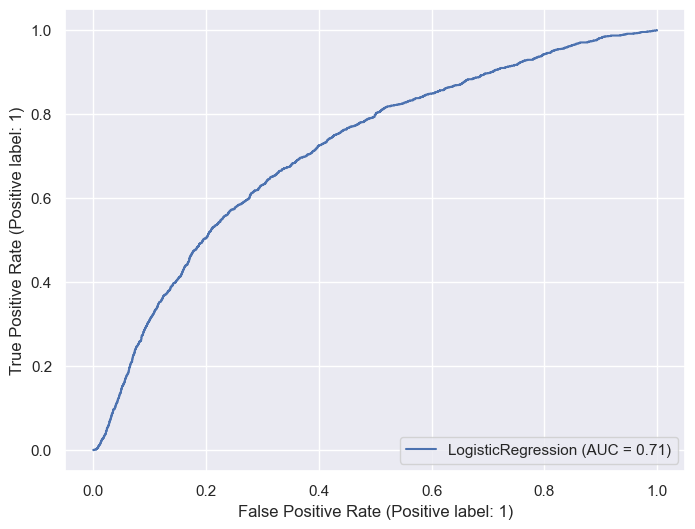

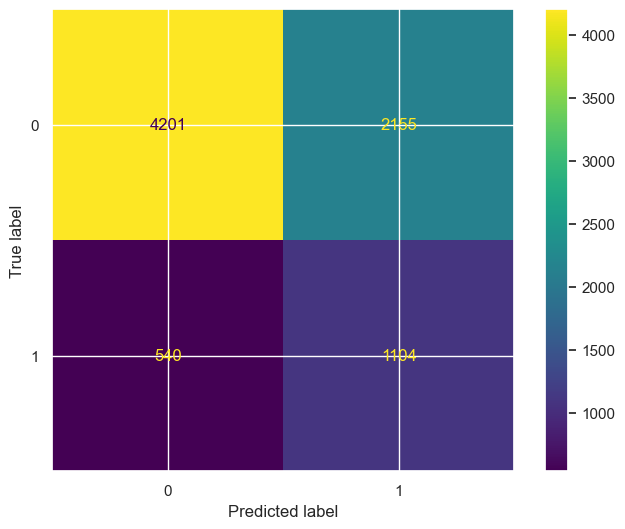

In [26]:
sns.set(rc={'figure.figsize':(8, 6)});
scoring(lr_grid.best_estimator_, X_train, y_train)

Итак, F1 = 0.45 AUC = 0.71

### Случайный лес
Не будем придумывать ничего нового

In [27]:
# выделим параметры для перебора
rfc_param_grid = {'max_depth': range(1, 10),
                  'min_samples_split': range(2, 10, 2),
                  'max_features': ['log2', 'sqrt']}

# объявим модель
rfc = RandomForestClassifier(n_estimators=20, random_state=42)

rfc_grid = GridSearchCV(rfc, rfc_param_grid, scoring='f1')
rfc_grid.fit(X_train, y_train)
rfc_grid.best_estimator_

RandomForestClassifier(max_depth=9, max_features='log2', min_samples_split=4,
                       n_estimators=20, random_state=42)

Оценим метрики

F1 = 0.65


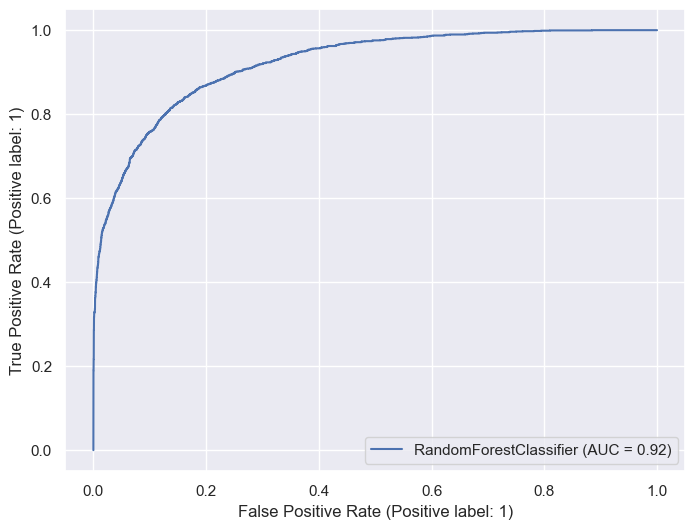

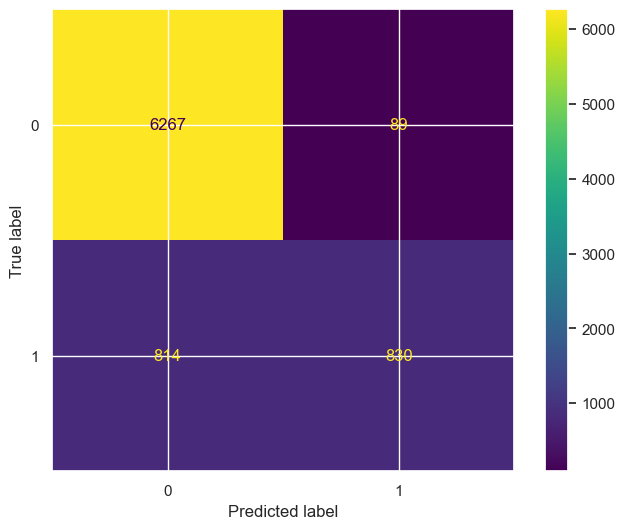

In [28]:
scoring(rfc_grid.best_estimator_, X_train, y_train)

F1 = 0.65, ROC AUC = 0.92. Модель корректно прогнозирует уход в половине случаев.

### CatBoost
Начнем с выделения категориальных признаков и создания Pool

In [29]:
X_train.columns

Index(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Geography_Germany',
       'Geography_Spain', 'Gender_Male'],
      dtype='object')

In [31]:
cat_features = ['HasCrCard', 'IsActiveMember', 'Geography_Germany', 
                'Geography_Spain', 'Gender_Male']

train_data = Pool(data=X_train,
                  label=y_train,
                  cat_features=cat_features)

Определим параметры и создадим копию класса модели

In [32]:
param_grid = {'depth': [4, 6, 8, 10],
         'l2_leaf_reg': [1, 3, 5, 7, 9], 
         'learning_rate': [0.015, 0.03, 0.1],
         'iterations': [100, 500, 1000]}
         
cb = CatBoostClassifier(loss_function='Logloss',
              eval_metric='F1',
              random_seed= 42,
              verbose=False,
              early_stopping_rounds=100,
              auto_class_weights='Balanced')

Узнаем лучший набор параметров

In [36]:
%%time
grid_search_result = cb.grid_search(param_grid,
                                        X=X_train,
                                        y=y_train,
                                        cv=5,
                                        partition_random_seed=42,
                                        refit=True,
                                        shuffle=True,
                                        stratified=None,
                                        verbose=False)


bestTest = 0.758074829
bestIteration = 97


bestTest = 0.7639683157
bestIteration = 59


bestTest = 0.7685227971
bestIteration = 23


bestTest = 0.7590370976
bestIteration = 97


bestTest = 0.7668520686
bestIteration = 82


bestTest = 0.7685227971
bestIteration = 24


bestTest = 0.758074829
bestIteration = 99


bestTest = 0.7638110451
bestIteration = 81


bestTest = 0.7661382731
bestIteration = 29


bestTest = 0.758395314
bestIteration = 88


bestTest = 0.7614353888
bestIteration = 2


bestTest = 0.7606463187
bestIteration = 65


bestTest = 0.7571149972
bestIteration = 89


bestTest = 0.7656451483
bestIteration = 74


bestTest = 0.7644537139
bestIteration = 31

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7596799683
bestIteration = 117

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7639683157
bestIteration = 59

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7685227971
bestIteration = 23

Stopped by overfitting detec

In [37]:
grid_search_result['params']

{'depth': 8, 'l2_leaf_reg': 7, 'iterations': 100, 'learning_rate': 0.1}

Получили наилучший набор. Настроим модель заново с его учетом

In [38]:
cb = CatBoostClassifier(**grid_search_result['params'], 
                        loss_function='Logloss',
                        eval_metric='F1',
                        random_seed= 290822,
                        verbose=False,
                        early_stopping_rounds=100,
                        auto_class_weights='Balanced')
cb.fit(train_data)

F1 = 0.66


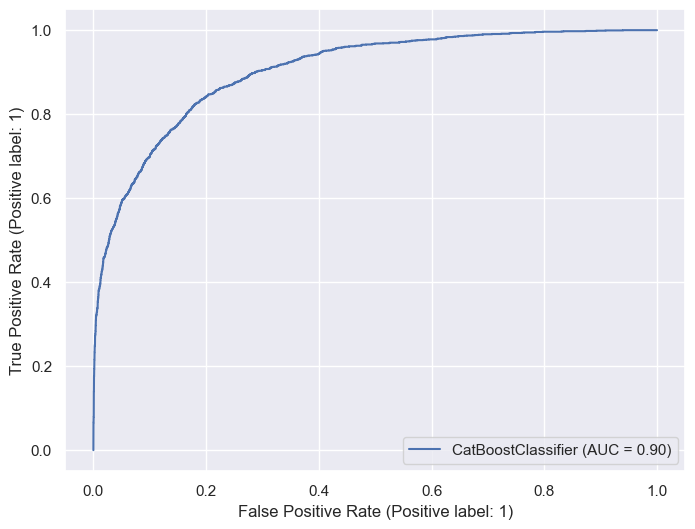

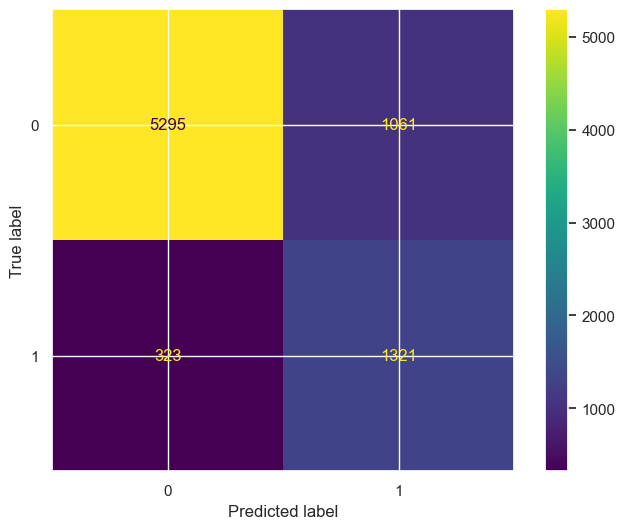

In [40]:
scoring(cb, X_train, y_train)

F1 = 0.66, ROC AUC = 0.90

### Вывод
Самой оптимальной моделью оказался CatBoost c точки зрения F1-меры. Случайны лес показал лучший ROC AUC

## Тестирование модели
### Тестируем

Волнительный момент

F1 = 0.62


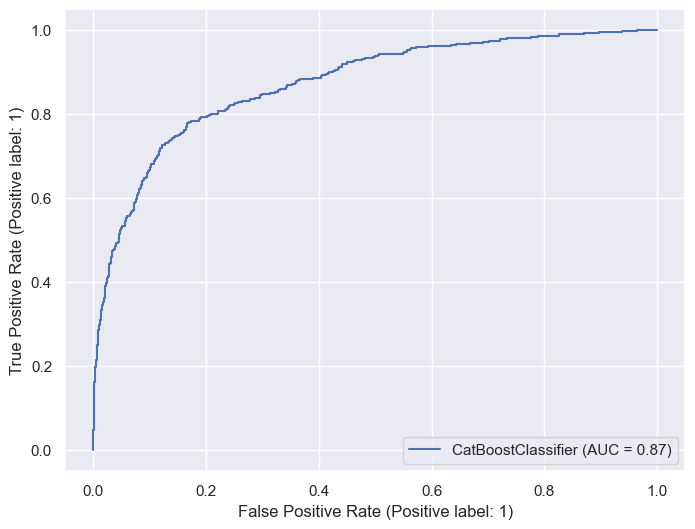

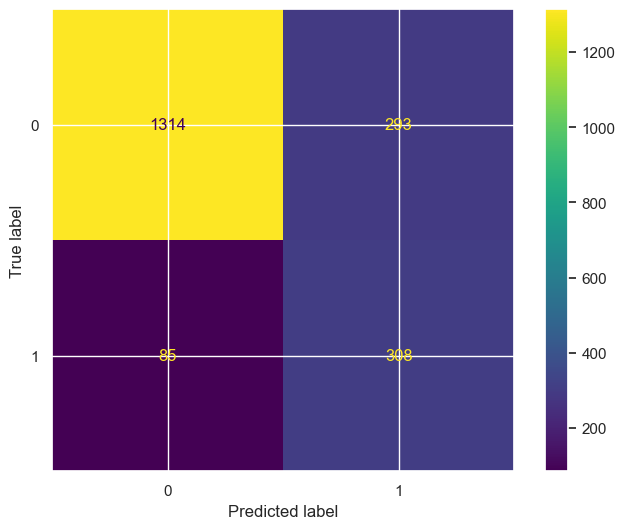

In [42]:
scoring(cb, X_test, y_test)

**Финальные результаты**
* F1-мера: 0.62
* AUC-ROC: 0.87